
## Machine learning notebook
This notebook performs data loading, outlier removal and data normalization and executes SVM, LightGBM and LDA algorithms. This version of the notebook has been optimized for the raw data set 6 in RawData_6.csv.

### Load required packages

In [1]:
import plotly.io as pio
import plotly.graph_objects as go
import plotly.express as px
import ipywidgets as widgets
from ipywidgets import HBox,VBox
import plotly.figure_factory as ff
import plotly.offline as plt_off
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sklearn.cluster as cluster
from collections import defaultdict
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from statannot import add_stat_annotation
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from sklearn.model_selection import StratifiedShuffleSplit

import warnings
warnings.filterwarnings('ignore')

### Define data paths and load as dataframe

In [2]:
# Input directory
dbs=[r'B:\Project - PD\LRRK2 paper\RawData_6.csv']

print(dbs[0])

# Output directory
output_path = 'B:/Project - PD/LRRK2 paper/Figures/RawData_6/'

if not os.path.exists(output_path):
    os.makedirs(output_path, exist_ok=True)
    
main_df_tot = pd.read_csv(dbs[0])

B:\Project - PD\LRRK2 paper\RawData_6.csv


### Specify data tags/classes
Used genotypes (i.e. Mutant, WT) and treatment condition (i.e. DMSO, compound X) are specified here.

In [3]:
main_df_tot.dropna(inplace=True)

whole_df = main_df_tot.copy()
main_df_tot = main_df_tot.set_index(['Plate', 'Well'])

display(main_df_tot.tags.value_counts())

ctrl_pos = 'DMSO;WT'
ctrl_neg = 'DMSO;Tripli'

# Define order for plotting
order = [ctrl_pos, ctrl_neg,'GNE;Tripli','Mli;Tripli', 'PFE;Tripli']

# Define pairs for statisitical tests shown in swarm-boxplots
box_pairs = [(ctrl_neg, ctrl_pos), (ctrl_neg, 'GNE;Tripli'), (ctrl_neg, 'Mli;Tripli'), (ctrl_neg, 'PFE;Tripli')]

DMSO;Tripli    140
GNE;Tripli      84
PFE;Tripli      84
Mli;Tripli      84
DMSO;WT         60
GNE;WT          36
PFE;WT          36
Mli;WT          36
Name: tags, dtype: int64

### Define Functions : Outliers removing and Normalization
Outlier removal possible with different methods (mean +- N sigmas or median +- inter-quartiles distance) & Normalization possible with different methods (standardization, quantiles based standardization, by mean, min-max)

In [4]:
def remove_outliers_by_plate(df_in, sigma, method, neg, pos):

    print('[DATA BEFORE OUTLIERS:]', len(df_in))

    list_df_plate = []

    df_in['Plate2'] = df_in.index.get_level_values('Plate')

    for plate in np.unique(df_in['Plate2']):

        df_plate = pd.DataFrame(df_in[df_in['Plate2'] == plate])

        data_neg = df_plate[df_plate['tags'] == neg]
        data_pos = df_plate[df_plate['tags'] == pos]
        data_cpd = df_plate[~((df_plate['tags'] == neg) | (df_plate['tags'] == pos))]

        print('CPDS LEN = ', len(data_cpd))

        data_neg = data_neg.drop(['Plate2', 'tags'], axis=1, errors='ignore')
        data_pos = data_pos.drop(['Plate2', 'tags'], axis=1, errors='ignore')
        data_cpd = data_cpd.drop(['Plate2'], axis=1, errors='ignore')

        data_neg = data_neg.astype(np.float64)
        data_pos = data_pos.astype(np.float64)

        if method == 'std':
            data_neg = data_neg[np.abs(data_neg - data_neg.mean()) / data_neg.std() <= sigma].dropna()
            data_pos = data_pos[np.abs(data_pos - data_pos.mean()) / data_pos.std() <= sigma].dropna()

        elif method == 'std_quartiles':
            data_neg = data_neg[np.abs(data_neg - data_neg.median()) <= sigma * np.abs(data_neg.quantile(0.75) - data_neg.quantile(0.25))].dropna()
            data_pos = data_pos[np.abs(data_pos - data_pos.median()) <= sigma * np.abs(data_pos.quantile(0.75) - data_pos.quantile(0.25))].dropna()

        data_neg['tags'] = neg
        data_pos['tags'] = pos

        df = pd.concat([data_neg, data_pos, data_cpd])
        list_df_plate.append(df)

    df_concat = pd.concat(list_df_plate)

    print('[DATA AFTER OUTLIERS:]', df_concat.shape[0])

    return df_concat

def norm_centered_by_plate(df, norm_type, neg, pos):

    df['Plate2'] = df.index.get_level_values('Plate')

    list_df_group = []

    for plate in np.unique(df['Plate2']):

        df_plate = df[df['Plate2'] == plate]

        neg_group = pd.DataFrame(df_plate[df_plate['tags'] == neg])
        pos_group = pd.DataFrame(df_plate[df_plate['tags'] == pos])

        for column in df_plate:
            if column != 'Plate2' and column != 'tags':

                mean_neg = np.mean(neg_group[column])
                mean_pos = np.mean(pos_group[column])
                median_neg = np.median(neg_group[column])
                diff_quartile_neg = np.abs(np.quantile(neg_group[column], 0.75) - np.quantile(neg_group[column], 0.25)) / 2.

                std_neg = np.std(neg_group[column])
                std_pos = np.std(pos_group[column])

                min_neg = np.min(neg_group[column])
                max_neg = np.max(neg_group[column])

                min_pos = np.min(pos_group[column])
                max_pos = np.max(pos_group[column])

                min_5sigma_neg = 0.
                min_5sigma_pos = 0.
                max_5sigma_neg = 0.
                max_5sigma_pos = 0.

                if norm_type == 'std':
                    if std_neg == 0:
                        std_neg = 1.

                    print(column, median_neg, std_neg)

                    df_plate[column] = (df_plate[column] - median_neg) / std_neg

                if norm_type == 'std_quartiles':
                    if diff_quartile_neg == 0:
                        diff_quartile_neg = 1.

                    print(column, median_neg, diff_quartile_neg)

                    df_plate[column] = (df_plate[column] - median_neg) / diff_quartile_neg

                if norm_type == 'mean':
                    if mean_neg == 0:
                        mean_neg = 1
                    df_plate[column] = df_plate[column] / mean_neg

                if norm_type == 'min_max':

                    sigma = 5

                    if mean_neg < mean_pos:
                        min_5sigma_neg = mean_neg - sigma * std_neg
                        max_5sigma_pos = mean_pos + sigma * std_pos

                        if min_5sigma_neg > min_neg:
                            min_neg = min_5sigma_neg

                        if max_5sigma_pos < max_pos:
                            max_pos = max_5sigma_pos

                    if mean_pos < mean_neg:
                        min_5sigma_pos = mean_pos - sigma * std_pos
                        max_5sigma_neg = mean_neg + sigma * std_neg

                        if min_5sigma_pos > min_pos:
                            min_pos = min_5sigma_pos

                        if max_5sigma_neg < max_neg:
                            max_neg = max_5sigma_neg

                    df_plate[column] -= min_neg

                    if (max_neg - min_neg) != 0:
                        df_plate[column] /= (max_neg - min_neg)
                    else:
                        df_plate[column] /= 1.

        list_df_group.append(df_plate)

    normalized_df = pd.concat(list_df_group)
    normalized_df.drop('Plate2', axis=1, inplace=True)

    print('[DATA NORMALIZED]')

    return normalized_df


### Data pre-processing (outlier removal & normalization)
All input image features and statisitical thresholds for outlier removal and normalization are listed. Some image features could not be calculated or were deemed irrelevant and where excluded (commented out).

In [5]:
# All image features to be used
selected_features = ['Cell_Correlation_MAP2_SNCA', 
            'Cell_Correlation_TH_SNCA', 
            'Cell_Correlation_VanSteelselsMeanX_TH_SNCA', 
            'Cell_Correlation_VanSteelselsMeanY_TH_SNCA', 
            'Cell_Correlation_VanSteelselsSigmaX_TH_SNCA', 
            'Cell_Correlation_VanSteelselsSigmaY_TH_SNCA', 
            'Cell_Intensity_MeanIntensity_MAP2', 
            'Cell_Intensity_MeanIntensity_SNCA', 
            'Cell_Intensity_MeanIntensity_TH', 
            'Cell_Intensity_SumIntensityPerNuclei_SNCA', 
            'Cell_MAP2_SNCA_Intensity_MeanIntensity_SNCA', 
            'Cell_Neurites_BranchingPointsPerNuclei_MAP2', 
            'Cell_Neurites_BranchingPointsPerNuclei_TH', 
            'Cell_Neurites_LengthPerNuclei_MAP2', 
            'Cell_Neurites_LengthPerNuclei_TH', 
            'Cell_Neurites_Length_MAP2', 
            'Cell_Neurites_Length_TH',
            'Cell_SurfacePerNuclei_MAP2', 
            'Cell_SurfacePerNuclei_MAP2_SNCA', 
            'Cell_SurfacePerNuclei_SNCA', 
            'Cell_SurfacePerNuclei_TH', 
            'Cell_SurfacePerNuclei_TH_SNCA', 
            'Cell_Surface_RatioSurface_TH_SNCA', 
            'Cell_Surface_TotalSurface_MAP2', #
            'Cell_Surface_TotalSurface_SNCA', #
            'Cell_Surface_TotalSurface_SNCA_MAP2',# 
            'Cell_Surface_TotalSurface_TH', #
            'Cell_Surface_TotalSurface_TH_SNCA',#
            'Cell_TH_SNCA_Intensity_MeanIntensity_SNCA', 
            'Cell_TH_SNCA_Intensity_MeanIntensity_TH', 
            'Cell_TH_SNCA_Intensity_SumIntensityPerNuclei_SNCA', 
            'Cell_Texture_SNCA_AngularSecondMoment_000', 
            'Cell_Texture_SNCA_AngularSecondMoment_045', 
            'Cell_Texture_SNCA_AngularSecondMoment_090', 
            'Cell_Texture_SNCA_AngularSecondMoment_135', 
            'Cell_Texture_SNCA_Contrast_000', 
            'Cell_Texture_SNCA_Contrast_045', 
            'Cell_Texture_SNCA_Contrast_090', 
            'Cell_Texture_SNCA_Contrast_135', 
            'Cell_Texture_SNCA_Correlation_000', 
            'Cell_Texture_SNCA_Correlation_045', 
            'Cell_Texture_SNCA_Correlation_090', 
            'Cell_Texture_SNCA_Correlation_135', 
            'Cell_Texture_SNCA_DifferenceEntropy_000', 
            'Cell_Texture_SNCA_DifferenceEntropy_045', 
            'Cell_Texture_SNCA_DifferenceEntropy_090', 
            'Cell_Texture_SNCA_DifferenceEntropy_135', 
            'Cell_Texture_SNCA_DifferenceVariance_000', 
            'Cell_Texture_SNCA_DifferenceVariance_045', 
            'Cell_Texture_SNCA_DifferenceVariance_090', 
            'Cell_Texture_SNCA_DifferenceVariance_135', 
            'Cell_Texture_SNCA_Entropy_000', 
            'Cell_Texture_SNCA_Entropy_045', 
            'Cell_Texture_SNCA_Entropy_090', 
            'Cell_Texture_SNCA_Entropy_135', 
            'Cell_Texture_SNCA_InfoMeasuresOfCorr1_000', 
            'Cell_Texture_SNCA_InfoMeasuresOfCorr1_045', 
            'Cell_Texture_SNCA_InfoMeasuresOfCorr1_090', 
            'Cell_Texture_SNCA_InfoMeasuresOfCorr1_135', 
            'Cell_Texture_SNCA_InfoMeasuresOfCorr2_000', 
            'Cell_Texture_SNCA_InfoMeasuresOfCorr2_045', 
            'Cell_Texture_SNCA_InfoMeasuresOfCorr2_090', 
            'Cell_Texture_SNCA_InfoMeasuresOfCorr2_135', 
            'Cell_Texture_SNCA_InverseDiffMoment_000', 
            'Cell_Texture_SNCA_InverseDiffMoment_045', 
            'Cell_Texture_SNCA_InverseDiffMoment_090', 
            'Cell_Texture_SNCA_InverseDiffMoment_135', 
            'Cell_Texture_SNCA_SumAverage_000', 
            'Cell_Texture_SNCA_SumAverage_045', 
            'Cell_Texture_SNCA_SumAverage_090', 
            'Cell_Texture_SNCA_SumAverage_135', 
            'Cell_Texture_SNCA_SumEntropy_000', 
            'Cell_Texture_SNCA_SumEntropy_045', 
            'Cell_Texture_SNCA_SumEntropy_090', 
            'Cell_Texture_SNCA_SumEntropy_135', 
            'Cell_Texture_SNCA_SumOfSquares_000', 
            'Cell_Texture_SNCA_SumOfSquares_045', 
            'Cell_Texture_SNCA_SumOfSquares_090', 
            'Cell_Texture_SNCA_SumOfSquares_135', 
            'Cell_Texture_SNCA_SumVariance_000', 
            'Cell_Texture_SNCA_SumVariance_045', 
            'Cell_Texture_SNCA_SumVariance_090', 
            'Cell_Texture_SNCA_SumVariance_135', 
            'Cytoplasm_Intensity_MeanIntensity_SNCA', 
            'Cytoplasm_MAP2_SNCA_Intensity_MeanIntensity_SNCA', 
            'Cytoplasm_SurfacePerNuclei_SNCA', 
            'Cytoplasm_SurfacePerNuclei_TH_SNCA', 
            'Cytoplasm_Surface_TotalSurface_SNCA', 
            'IndividualCell_Intensity_MeanIntensity_SNCA', 
            'IndividualCell_Intensity_RadialProfile_InterceptFit_SNCA',
            'IndividualCell_Intensity_RadialProfile_MaxSlope_SNCA', 
            'IndividualCell_Intensity_RadialProfile_Maximum_SNCA', 
            'IndividualCell_Intensity_RadialProfile_MeanCoeffVar_SNCA', 
            'IndividualCell_Intensity_RadialProfile_MeanGradient_SNCA', 
            'IndividualCell_Intensity_RadialProfile_Mean_SNCA', 
            'IndividualCell_Intensity_RadialProfile_Median_SNCA', 
            'IndividualCell_Intensity_RadialProfile_Minimum_SNCA', #
            'IndividualCell_Intensity_RadialProfile_Q1_SNCA', 
            'IndividualCell_Intensity_RadialProfile_Q3_SNCA', 
            'IndividualCell_Intensity_RadialProfile_SlopeFit_SNCA', 
            'IndividualCell_Intensity_RadialProfile_StdCoeffVar_SNCA', 
            'IndividualCell_Intensity_RadialProfile_Std_SNCA', 
            'IndividualCell_Intensity_SumIntensity_SNCA', 
            'IndividualCell_Surface_MeanSurface_SNCA', 
            'Membrane_Intensity_MeanIntensity_MAP2', 
            'Membrane_Intensity_MeanIntensity_SNCA', 
            'Membrane_Intensity_MeanIntensity_TH', 
            'Membrane_Surface_SurfacePerNuclei_MAP2', 
            'Membrane_Surface_SurfacePerNuclei_SNCA', 
            'Membrane_Surface_SurfacePerNuclei_TH', 
            'Nuclei_Living_Ratio_MAP2', 
            'Nuclei_Living_Ratio_MAP2_SNCA', 
            #'Nuclei_Living_Ratio_SNCA', 
            'Nuclei_Living_Ratio_TH_SNCA', 
            'Nuclei_Number_Dead', 
            'Nuclei_Number_Living', 
            'Nuclei_Number_MAP2', 
            'Nuclei_Number_MAP2_SNCA', 
            'Nuclei_Number_SNCA', 
            'Nuclei_Number_TH', 
            'Nuclei_Number_TH_SNCA', 
            'Nuclei_Ratio_Dead', 
            'Nuclei_Ratio_Living', 
            'Nuclei_Surface_MeanArea',
            "tags"]

method_outliers  = 'std' # Outlier method: 'std' or 'std_quartiles'
outliers_sigma = 4 # Number of sigmas used for outlier removal

main_df = main_df_tot[selected_features]

display(main_df.tags.value_counts())

main_df_wo_outliers = pd.DataFrame()

if method_outliers == 'std':
    main_df_wo_outliers = remove_outliers_by_plate(main_df, outliers_sigma, 'std', ctrl_neg, ctrl_pos)
    main_df = norm_centered_by_plate(main_df_wo_outliers, 'std', ctrl_neg, ctrl_pos)
else:
    main_df_wo_outliers = remove_outliers_by_plate(main_df, outliers_sigma, 'std_quartiles', ctrl_neg, ctrl_pos)
    main_df = norm_centered_by_plate(main_df_wo_outliers, 'std_quartiles', ctrl_neg, ctrl_pos)

X_all_cpds = main_df[selected_features[:-1]]
Y_all_cpds = main_df['tags']

# Value counts per class after outlier removal and normalization
display(main_df.tags.value_counts())

df = main_df[main_df.tags.isin([ctrl_neg, ctrl_pos])]
X = df[selected_features[:-1]]
Y = df['tags']

whole_x = main_df[selected_features[:-1]]
whole_y = main_df['tags']

DMSO;Tripli    140
GNE;Tripli      84
PFE;Tripli      84
Mli;Tripli      84
DMSO;WT         60
GNE;WT          36
PFE;WT          36
Mli;WT          36
Name: tags, dtype: int64

[DATA BEFORE OUTLIERS:] 560
CPDS LEN =  180
CPDS LEN =  180
[DATA AFTER OUTLIERS:] 542
Cell_Correlation_MAP2_SNCA 0.110993 0.0521766745405844
Cell_Correlation_TH_SNCA 0.014934 0.013630733189666516
Cell_Correlation_VanSteelselsMeanX_TH_SNCA 19.8277 2.4382773605446078
Cell_Correlation_VanSteelselsMeanY_TH_SNCA 18.9869 2.501523983539331
Cell_Correlation_VanSteelselsSigmaX_TH_SNCA 0.750775 0.7838769643549248
Cell_Correlation_VanSteelselsSigmaY_TH_SNCA 0.732768 0.8139545314890017
Cell_Intensity_MeanIntensity_MAP2 918.607 69.45301194488495
Cell_Intensity_MeanIntensity_SNCA 522.847 40.468596790875836
Cell_Intensity_MeanIntensity_TH 407.741 93.52111737914483
Cell_Intensity_SumIntensityPerNuclei_SNCA 3414870.0 509848.08517864544
Cell_MAP2_SNCA_Intensity_MeanIntensity_SNCA 546.752 43.06987112596346
Cell_Neurites_BranchingPointsPerNuclei_MAP2 14.8517 2.341627745990069
Cell_Neurites_BranchingPointsPerNuclei_TH 7.97348 1.3044033087828673
Cell_Neurites_LengthPerNuclei_MAP2 1159.83 113.17856878850539

DMSO;Tripli    128
GNE;Tripli      84
PFE;Tripli      84
Mli;Tripli      84
DMSO;WT         54
GNE;WT          36
PFE;WT          36
Mli;WT          36
Name: tags, dtype: int64

### Summary of processed dataframe

In [6]:
X.describe(include='all')

,Cell_Correlation_MAP2_SNCA,Cell_Correlation_TH_SNCA,Cell_Correlation_VanSteelselsMeanX_TH_SNCA,Cell_Correlation_VanSteelselsMeanY_TH_SNCA,Cell_Correlation_VanSteelselsSigmaX_TH_SNCA,Cell_Correlation_VanSteelselsSigmaY_TH_SNCA,Cell_Intensity_MeanIntensity_MAP2,Cell_Intensity_MeanIntensity_SNCA,Cell_Intensity_MeanIntensity_TH,Cell_Intensity_SumIntensityPerNuclei_SNCA,...,Nuclei_Number_Dead,Nuclei_Number_Living,Nuclei_Number_MAP2,Nuclei_Number_MAP2_SNCA,Nuclei_Number_SNCA,Nuclei_Number_TH,Nuclei_Number_TH_SNCA,Nuclei_Ratio_Dead,Nuclei_Ratio_Living,Nuclei_Surface_MeanArea
count,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,...,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000
mean,0.057868,0.237780,0.022917,0.190576,0.170891,0.193442,-0.119470,0.139724,0.147722,-0.405305,...,-0.335363,-0.118617,0.103311,0.130641,-0.119045,-0.221736,-0.247289,-0.365516,0.365515,0.667774
std,1.006219,0.920560,1.120692,1.161883,0.929648,0.923934,1.312412,1.333639,0.957403,1.353670,...,1.141968,0.957609,1.026205,1.027689,0.957568,1.078952,1.086117,1.204992,1.204991,1.527698
min,-1.339073,-0.777429,-3.322797,-2.924577,-0.929556,-0.899789,-4.764228,-2.513579,-1.513799,-3.888786,...,-2.983302,-2.693301,-2.622769,-2.575168,-2.694779,-2.437854,-2.530362,-3.466343,-2.992428,-2.723480
25%,-0.616296,-0.342544,-0.759123,-0.573870,-0.391884,-0.358789,-0.898507,-0.712571,-0.532496,-1.169912,...,-1.106755,-0.785600,-0.533222,-0.500318,-0.785835,-0.954904,-0.967647,-1.056543,-0.410239,-0.332101
50%,-0.178453,-0.067106,-0.038640,0.000240,-0.075851,-0.097004,0.033627,-0.044714,-0.026759,-0.298650,...,-0.377633,-0.111383,0.104233,0.122134,-0.111333,-0.226813,-0.255073,-0.376392,0.376389,0.394181
75%,0.372175,0.495576,0.725492,0.870570,0.438141,0.488629,0.734042,0.721045,0.669191,0.539962,...,0.481482,0.508587,0.706709,0.749802,0.508743,0.550905,0.538098,0.410239,1.056553,1.501805
max,3.315573,6.125877,2.728976,3.495429,6.206656,6.130062,3.043514,5.208831,3.621108,2.546892,...,2.999889,2.544678,2.578811,2.634029,2.543520,1.990920,1.990226,2.992424,3.466343,7.412281


### Inspect individual image features
Each image feature can be plotted for both reference classes. Each data point represent data from a single well.

In [7]:
#df_ctrls = main_df[main_df.tags.isin([ctrl_neg, ctrl_pos])]
#df_ctrls_neg = df_ctrls[df_ctrls.tags==ctrl_neg]
#df_ctrls_pos = df_ctrls[df_ctrls.tags==ctrl_pos]

#for col in df_ctrls.columns:
    
     #if col != 'tags':

         #fig = px.histogram(df_ctrls, x=col, color="tags", title=col, nbins=100)
         #fig.show() 

         #feat_zfactor = 1 - 3*(df_ctrls_neg[col].std()+df_ctrls_pos[col].std()) / np.abs(df_ctrls_neg[col].mean()-df_ctrls_pos[col].mean())

         #print('ZFactor', col, feat_zfactor)  

### Define Cross Validation with Z Factor as score for Classification Methods :
Computes the Z Factors in function of N different shuffled training/testing sets

In [8]:
def cross_valid_z_prime(model, X, labels, iter_nb, train_set_proportion):

    list_z_train = []
    list_z_test = []

    for i in range(iter_nb):
        x_train, x_test, y_train, y_test = train_test_split(X, labels, train_size=train_set_proportion, stratify=labels,
                                                            random_state=i)
        model.fit(x_train, y_train)

        accuracy_train = model.score(x_train, y_train)
        accuracy_test = model.score(x_test, y_test)

        x_neg_train = model.transform(x_train[y_train == 0])
        x_pos_train = model.transform(x_train[y_train == 1])

        z_train = 1.0 - 3.0 * (np.std(x_neg_train) + np.std(x_pos_train)) / np.abs(
            np.mean(x_neg_train) - np.mean(x_pos_train))

        x_neg_test = model.transform(x_test[y_test == 0])
        x_pos_test = model.transform(x_test[y_test == 1])

        z_test = 1.0 - 3.0 * (np.std(x_neg_test) + np.std(x_pos_test)) / np.abs(np.mean(x_neg_test) - np.mean(x_pos_test))

        list_z_train.append(z_train)
        list_z_test.append(z_test)

    return list_z_train, list_z_test

def cross_valid_z_prime_svm(model, X, labels, iter_nb, train_set_proportion, output_path):

    list_z_train = []
    list_z_test = []

    for i in range(iter_nb):
        x_train, x_test, y_train, y_test = train_test_split(X, labels, train_size=train_set_proportion, stratify=labels,
                                                            random_state=i)

        model.fit(x_train, y_train)

        accuracy_train = model.score(x_train, y_train)
        accuracy_test = model.score(x_test, y_test)

        x_neg_train = model.predict_proba(x_train[y_train == 0])[:,0]
        x_pos_train = model.predict_proba(x_train[y_train == 1])[:,0]

        z_train = 1.0 - 3.0 * (np.std(x_neg_train) + np.std(x_pos_train)) / np.abs(
            np.mean(x_neg_train) - np.mean(x_pos_train))

        x_neg_test = model.predict_proba(x_test[y_test == 0])[:,0]
        x_pos_test = model.predict_proba(x_test[y_test == 1])[:,0]

        z_test = 1.0 - 3.0 * (np.std(x_neg_test) + np.std(x_pos_test)) / np.abs(np.mean(x_neg_test) - np.mean(x_pos_test))

        list_z_train.append(z_train)
        list_z_test.append(z_test)

    return list_z_train, list_z_test

def cross_valid_z_prime_linear_svm(model, X, labels, iter_nb, train_set_proportion, output_path):

    list_z_train = []
    list_z_test = []

    for i in range(iter_nb):
        x_train, x_test, y_train, y_test = train_test_split(X, labels, train_size=train_set_proportion, stratify=labels,
                                                            random_state=i)

        model.fit(x_train, y_train)

        accuracy_train = model.score(x_train, y_train)
        accuracy_test = model.score(x_test, y_test)

        x_neg_train = model.decision_function(x_train[y_train == 0])
        x_pos_train = model.decision_function(x_train[y_train == 1])

        z_train = 1.0 - 3.0 * (np.std(x_neg_train) + np.std(x_pos_train)) / np.abs(
            np.mean(x_neg_train) - np.mean(x_pos_train))

        x_neg_test = model.decision_function(x_test[y_test == 0])
        x_pos_test = model.decision_function(x_test[y_test == 1])

        z_test = 1.0 - 3.0 * (np.std(x_neg_test) + np.std(x_pos_test)) / np.abs(np.mean(x_neg_test) - np.mean(x_pos_test))

        list_z_train.append(z_train)
        list_z_test.append(z_test)

    return list_z_train, list_z_test

### LDA classifier with all image features
Regularized Classification of the data using LDA

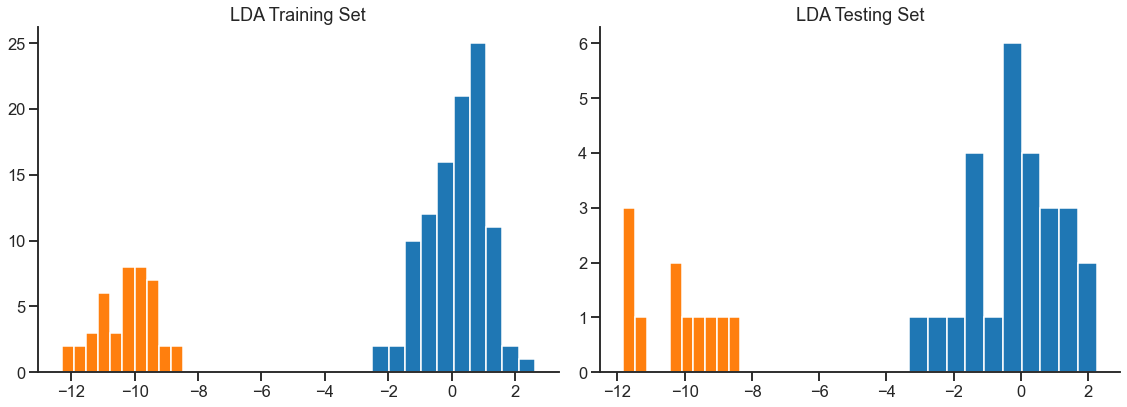

Cross valid Accuracy: 1.00 (+/- 0.00)




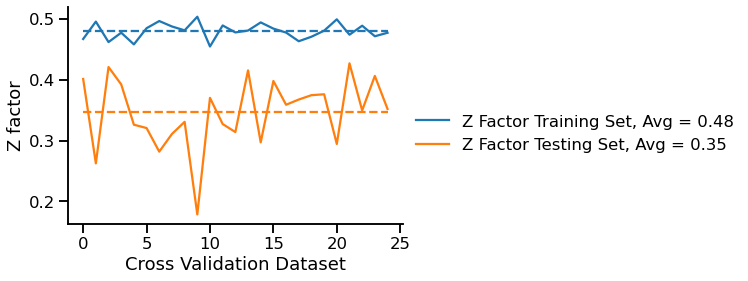

In [9]:
output_path_all = output_path+'/lda_all_features/'

if not os.path.exists(output_path_all):
	os.makedirs(output_path_all, exist_ok=True)

train_set_proportion = 0.8
shrink = 'auto'

le = LabelEncoder() 
Y = le.fit_transform(Y)

x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size=train_set_proportion, stratify=Y, random_state=100)

lda_analysis = LDA(solver='eigen', n_components=1, shrinkage=shrink)
lda_analysis.fit(x_train, y_train)

LDA_train = lda_analysis.transform(x_train)
LDA_test = lda_analysis.transform(x_test)

df_training_set = pd.DataFrame()

with sns.axes_style("white"), sns.axes_style("ticks"), sns.plotting_context("talk"):
	fig, axes = plt.subplots(figsize=(16, 6), nrows=1, ncols=2)
	axes[0].hist(LDA_train[y_train==0], label=ctrl_neg)
	axes[0].hist(LDA_train[y_train==1], label=ctrl_pos)
	axes[0].set_title('LDA Training Set')
	axes[1].hist(LDA_test[y_test==0], label=ctrl_neg)
	axes[1].hist(LDA_test[y_test==1], label=ctrl_pos)
	axes[1].set_title('LDA Testing Set')
	plt.tight_layout()
	sns.despine()
	plt.savefig(output_path_all+'LDA_training_test_set_shrinkage_'+str(shrink)+'_all_set.pdf', bbox_inches='tight')
	plt.show()

from sklearn.model_selection import cross_val_score
scores = cross_val_score(lda_analysis, X, Y, cv=10)
print("Cross valid Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))
print('\n')

list_z_train, list_z_test = cross_valid_z_prime(lda_analysis, X, Y, 25, train_set_proportion)

xpoints = range(len(list_z_test))

training = ['Training'] * len(list_z_train)
testing = ['Testing'] * len(list_z_test)

training_df = pd.DataFrame(
    {'Y': list_z_train,
     'X': xpoints,
     'Hue': training
    })

testing_df = pd.DataFrame(
    {'Y': list_z_test,
     'X': xpoints,
     'Hue': testing
    })

test_train = training_df.append(testing_df).reset_index(drop=True)

sns.set_context("talk")                
ax = sns.lineplot(data=test_train, x='X', y='Y', hue='Hue')
ax.set(xlabel='Cross Validation Dataset', ylabel='Z factor')
plt.hlines(np.mean(list_z_train), 0, len(list_z_train)-1, colors=sns.color_palette()[0], linestyles='dashed')
plt.hlines(np.mean(list_z_test), 0, len(list_z_test)-1, colors=sns.color_palette()[1], linestyles='dashed')
sns.despine()
# Put the legend out of the figure and remove title
handles, labels = ax.get_legend_handles_labels()
ax.legend(['Z Factor Training Set, Avg = '+"%.2f" % np.mean(list_z_train), 
           'Z Factor Testing Set, Avg = '+"%.2f" % np.mean(list_z_test)], handles=handles[2:], labels=labels[2:], bbox_to_anchor=(1.02, 0.3), loc=3, borderaxespad=0., 
           frameon=False)
plt.savefig(output_path_all+'LDA_CV_ZFactor.pdf', bbox_inches='tight')




## Correlations : Feature Correlations :

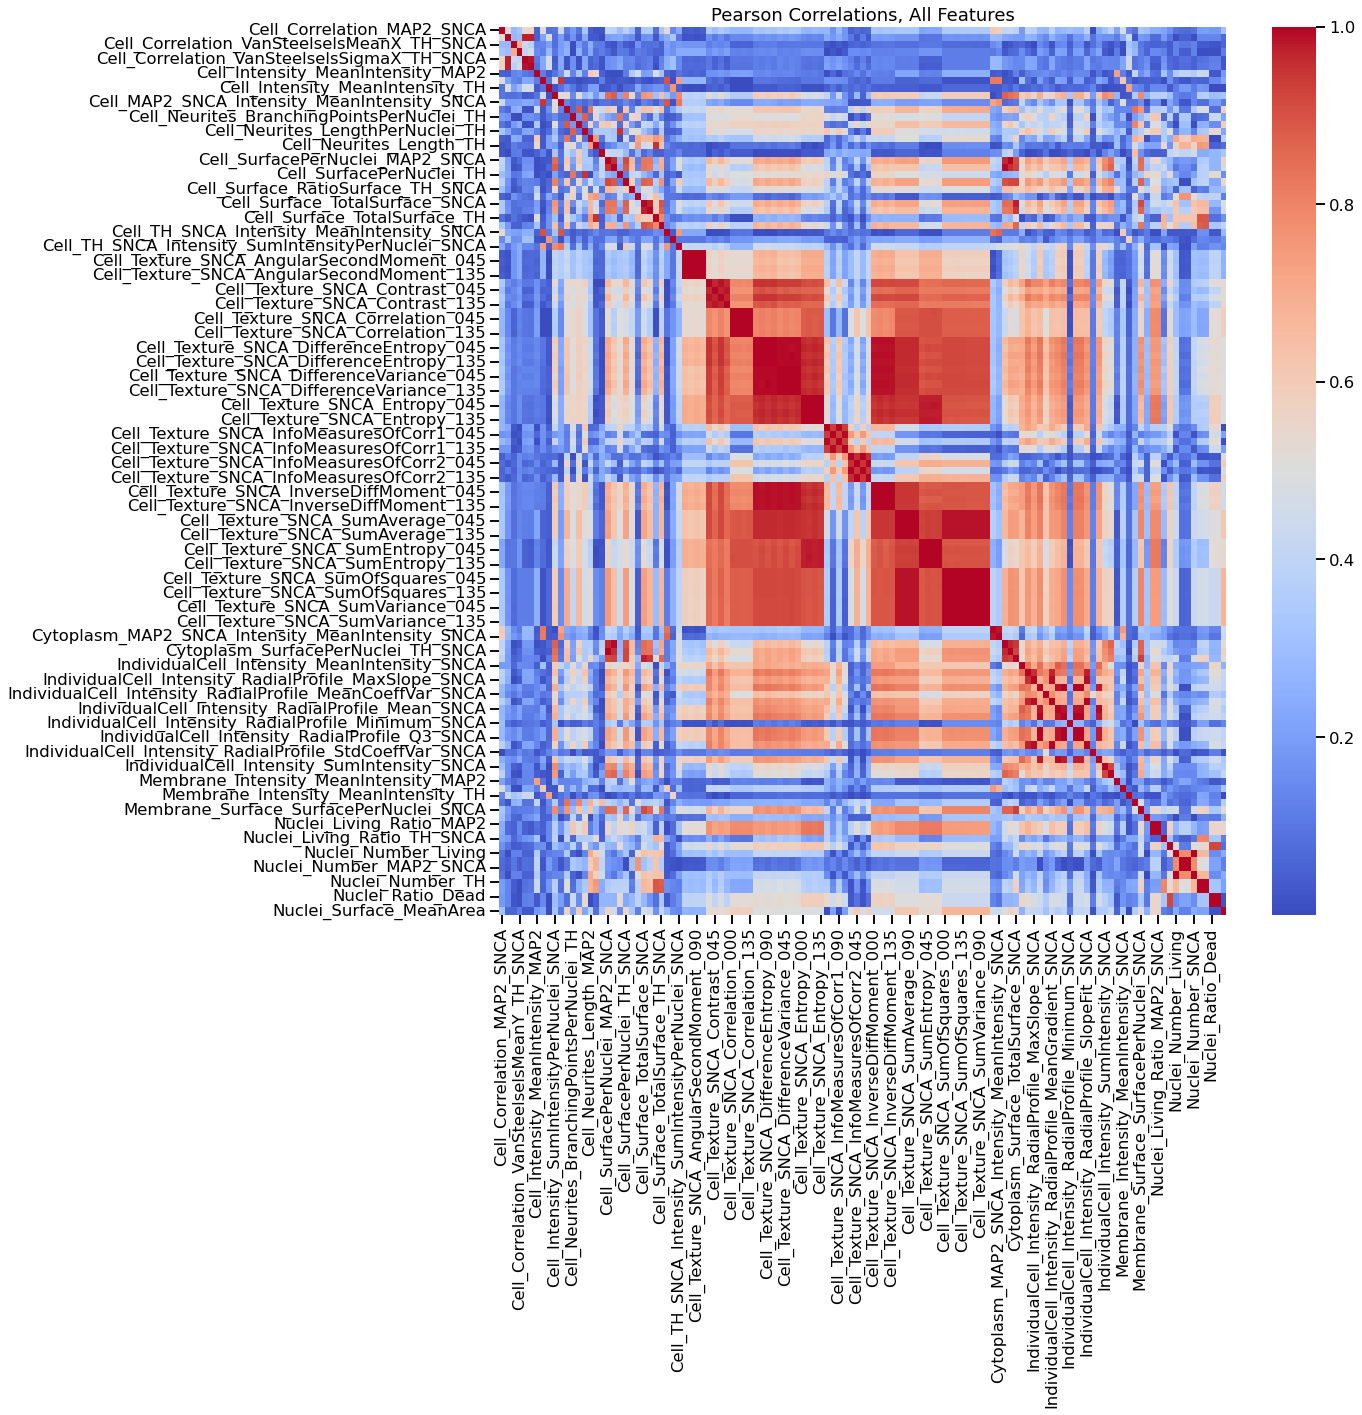

In [10]:
output_path_corr = output_path+'/Pearson_Correlations/'

if not os.path.exists(output_path_corr):
	os.makedirs(output_path_corr, exist_ok=True)

correlations = X.corr().abs()

sns.set_context("talk", font_scale=1)
f, ax = plt.subplots(figsize=(20, 20))
h = sns.heatmap(correlations, cmap='coolwarm')
plt.title('Pearson Correlations, All Features')
plt.tight_layout()
plt.savefig(output_path_corr+"pearson_correlations_all_features.pdf", bbox_inches='tight')
plt.show()

### Loop through correlation thresholds
The goal is to identify the correlation threshold yielding the highest Z factor between the two reference classes as determined by LDA.

In [11]:
def apply_threhold_correlations(X, thr):
    corr_between_features = thr
    new_correlations = X.corr().abs()

    upper = new_correlations.where(np.triu(np.ones(new_correlations.shape), k=1).astype(np.bool))
    to_drop = [column for column in upper.columns if any(upper[column] > corr_between_features)]

    # print('Dropped Features :')
    # display(to_drop)
    print('New Feature Size = ', len(X.columns)-len(to_drop))

    df_X_without_correlated = X.copy()
    df_X_without_correlated.drop(to_drop, axis=1, inplace=True)

    return df_X_without_correlated

In [12]:
def classif_lda(X, Y, train_set_proportion = 0.8, shrink = 'auto'):

    x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size=train_set_proportion, stratify=Y, random_state=100)

    lda_analysis = LDA(solver='eigen', n_components=1, shrinkage=shrink)

    # print(x_train.columns)

    lda_analysis.fit(x_train, y_train)

    from sklearn.model_selection import cross_val_score
    scores = cross_val_score(lda_analysis, X, Y, cv=10)
    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

    list_z_train, list_z_test = cross_valid_z_prime(lda_analysis, X, Y, 25, train_set_proportion)

    return scores.mean(), list_z_train, list_z_test

### Plotting of correlation thresholds vs Z Factor and CV Accuracy

New Feature Size =  1
New Feature Size =  2
New Feature Size =  3
New Feature Size =  3
New Feature Size =  4
New Feature Size =  4
New Feature Size =  5
New Feature Size =  7
New Feature Size =  9
New Feature Size =  12
New Feature Size =  14
New Feature Size =  15
New Feature Size =  21
New Feature Size =  28
New Feature Size =  32
New Feature Size =  42
New Feature Size =  47
New Feature Size =  55
Accuracy: 0.80 (+/- 0.09)
Accuracy: 0.77 (+/- 0.09)
Accuracy: 0.90 (+/- 0.06)
Accuracy: 0.90 (+/- 0.06)
Accuracy: 0.90 (+/- 0.06)
Accuracy: 0.90 (+/- 0.06)
Accuracy: 0.89 (+/- 0.07)
Accuracy: 0.96 (+/- 0.04)
Accuracy: 0.97 (+/- 0.04)
Accuracy: 0.98 (+/- 0.03)
Accuracy: 0.98 (+/- 0.03)
Accuracy: 0.97 (+/- 0.04)
Accuracy: 0.99 (+/- 0.02)
Accuracy: 0.99 (+/- 0.02)
Accuracy: 0.99 (+/- 0.02)
Accuracy: 1.00 (+/- 0.00)
Accuracy: 1.00 (+/- 0.00)
Accuracy: 1.00 (+/- 0.00)


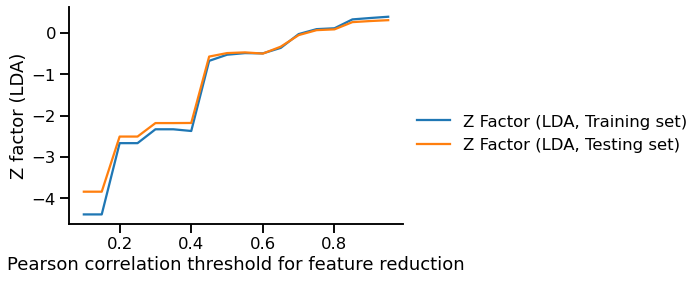

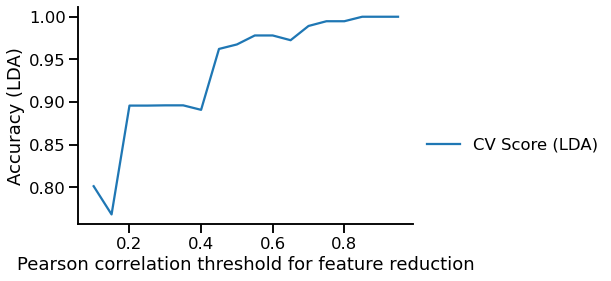

Threshold maximizing LDA Z Factor Test:  0.9500000000000003


In [13]:
list_df_thr_correlations = []
list_thr = []

for thr in np.arange(0.1, 1.0, 0.05):
    list_df_thr_correlations.append(apply_threhold_correlations(X, thr))
    list_thr.append(thr)

list_scores = []
list_avg_z_train = []
list_avg_z_test = []

for df_data in list_df_thr_correlations:
    scores, z_train, z_test = classif_lda(df_data, Y, train_set_proportion = 0.8, shrink = 'auto')
    list_scores.append(scores)
    list_avg_z_train.append(np.mean(z_train))
    list_avg_z_test.append(np.mean(z_test))

# Generating dataframe for plotting
training = ['Z Factor (LDA, Training set)'] * len(list_avg_z_train)
testing = ['Z Factor (LDA, Testing set)'] * len(list_avg_z_test)
LDA_CV_score = ['CV Score (LDA)'] * len(list_scores)

df_list_scores = pd.DataFrame(
    {'Y': list_scores,
     'X': list_thr,
     'Hue': LDA_CV_score
    })

df_avg_z_train = pd.DataFrame(
    {'Y': list_avg_z_train,
     'X': list_thr,
     'Hue': training
    })

df_avg_z_test = pd.DataFrame(
    {'Y': list_avg_z_test,
     'X': list_thr,
     'Hue': testing
    })

test_train = df_avg_z_train.append(df_avg_z_test).reset_index(drop=True)

# Plotting
sns.set_context("talk")                
ax = sns.lineplot(data=test_train, x='X', y='Y', hue='Hue')
ax.set(xlabel='Pearson correlation threshold for feature reduction', ylabel='Z factor (LDA)')
sns.despine()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[0:], labels=labels[0:], bbox_to_anchor=(1.02, 0.3), loc=3, borderaxespad=0., 
           frameon=False)
plt.savefig(output_path_corr+"lda_zfactor_function_correlation_thr.pdf", bbox_inches='tight')
plt.show()

ax1 = sns.lineplot(data=df_list_scores, x='X', y='Y', hue='Hue')
ax1.set(xlabel='Pearson correlation threshold for feature reduction', ylabel='Accuracy (LDA)')
sns.despine()
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles=handles[0:], labels=labels[0:], bbox_to_anchor=(1.02, 0.3), loc=3, borderaxespad=0., 
           frameon=False)
plt.savefig(output_path_corr+"lda_CVscore_function_correlation_thr.pdf", bbox_inches='tight')
plt.show()

threshold_validated = list_thr[np.argmax(list_avg_z_test)]

print('Threshold maximizing LDA Z Factor Test: ', threshold_validated)
    

### Remove Correlated Features above the defined threshold :

Dropped Features :


['Cell_Correlation_VanSteelselsSigmaX_TH_SNCA',
 'Cell_Correlation_VanSteelselsSigmaY_TH_SNCA',
 'Cell_SurfacePerNuclei_SNCA',
 'Cell_SurfacePerNuclei_TH',
 'Cell_Surface_TotalSurface_SNCA_MAP2',
 'Cell_Texture_SNCA_AngularSecondMoment_045',
 'Cell_Texture_SNCA_AngularSecondMoment_090',
 'Cell_Texture_SNCA_AngularSecondMoment_135',
 'Cell_Texture_SNCA_Contrast_045',
 'Cell_Texture_SNCA_Contrast_090',
 'Cell_Texture_SNCA_Contrast_135',
 'Cell_Texture_SNCA_Correlation_045',
 'Cell_Texture_SNCA_Correlation_090',
 'Cell_Texture_SNCA_Correlation_135',
 'Cell_Texture_SNCA_DifferenceEntropy_000',
 'Cell_Texture_SNCA_DifferenceEntropy_045',
 'Cell_Texture_SNCA_DifferenceEntropy_090',
 'Cell_Texture_SNCA_DifferenceEntropy_135',
 'Cell_Texture_SNCA_DifferenceVariance_000',
 'Cell_Texture_SNCA_DifferenceVariance_045',
 'Cell_Texture_SNCA_DifferenceVariance_090',
 'Cell_Texture_SNCA_DifferenceVariance_135',
 'Cell_Texture_SNCA_Entropy_000',
 'Cell_Texture_SNCA_Entropy_045',
 'Cell_Texture_SNCA_Ent

68

Index(['Cell_Correlation_MAP2_SNCA', 'Cell_Correlation_TH_SNCA',
       'Cell_Correlation_VanSteelselsMeanX_TH_SNCA',
       'Cell_Correlation_VanSteelselsMeanY_TH_SNCA',
       'Cell_Intensity_MeanIntensity_MAP2',
       'Cell_Intensity_MeanIntensity_SNCA', 'Cell_Intensity_MeanIntensity_TH',
       'Cell_Intensity_SumIntensityPerNuclei_SNCA',
       'Cell_MAP2_SNCA_Intensity_MeanIntensity_SNCA',
       'Cell_Neurites_BranchingPointsPerNuclei_MAP2',
       'Cell_Neurites_BranchingPointsPerNuclei_TH',
       'Cell_Neurites_LengthPerNuclei_MAP2',
       'Cell_Neurites_LengthPerNuclei_TH', 'Cell_Neurites_Length_MAP2',
       'Cell_Neurites_Length_TH', 'Cell_SurfacePerNuclei_MAP2',
       'Cell_SurfacePerNuclei_MAP2_SNCA', 'Cell_SurfacePerNuclei_TH_SNCA',
       'Cell_Surface_RatioSurface_TH_SNCA', 'Cell_Surface_TotalSurface_MAP2',
       'Cell_Surface_TotalSurface_SNCA', 'Cell_Surface_TotalSurface_TH',
       'Cell_Surface_TotalSurface_TH_SNCA',
       'Cell_TH_SNCA_Intensity_MeanIntensit

'FinalFeatures : '

55

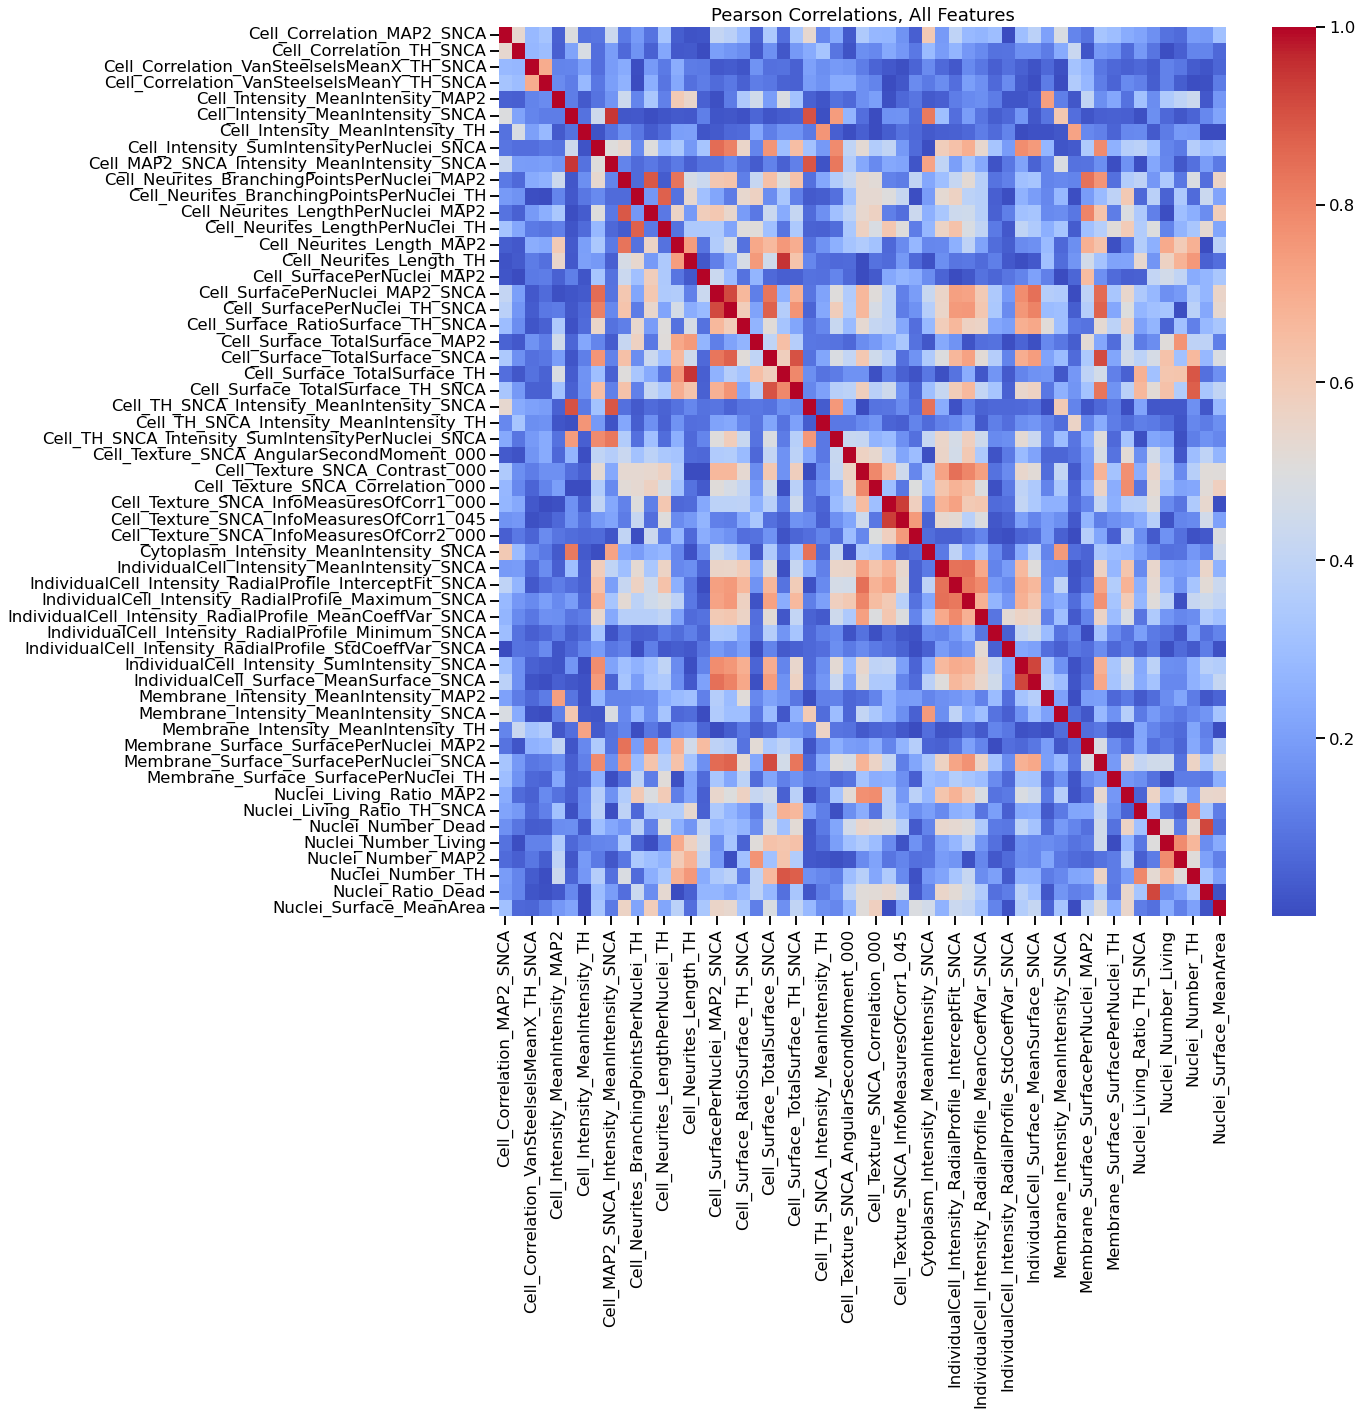

In [14]:
corr_between_features = threshold_validated #correlation threshold between features
new_correlations = X.corr().abs()

upper = new_correlations.where(np.triu(np.ones(new_correlations.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > corr_between_features)]

print('Dropped Features :')
display(to_drop)
display(len(to_drop))

df_X_without_correlated = X.copy()
df_X_without_correlated.drop(to_drop, axis=1, inplace=True)

display(df_X_without_correlated.columns)
display('FinalFeatures : ', len(df_X_without_correlated.columns))

sns.set_context("talk", font_scale=1)
f, ax = plt.subplots(figsize=(20, 20))
h = sns.heatmap(df_X_without_correlated.corr().abs(), cmap='coolwarm')
plt.title('Pearson Correlations, All Features')
plt.tight_layout()
plt.savefig(output_path_corr+"person_correlations_after_selection.pdf", bbox_inches='tight')
plt.show()


### LightGBM Analysis
Fit of two previously selected reference classes to identify features which contribute the most to reference class separation. 

There are 16 features with 0.0 importance
    index                                            feature  importance  \
0      34  IndividualCell_Intensity_RadialProfile_Interce...       2.225   
1       0                         Cell_Correlation_MAP2_SNCA       1.280   
2       4                  Cell_Intensity_MeanIntensity_MAP2       1.035   
3       1                           Cell_Correlation_TH_SNCA       0.285   
4      27                     Cell_Texture_SNCA_Contrast_000       0.090   
5       2         Cell_Correlation_VanSteelselsMeanX_TH_SNCA       0.080   
6       5                  Cell_Intensity_MeanIntensity_SNCA       0.040   
7      42              Membrane_Intensity_MeanIntensity_SNCA       0.040   
8      23          Cell_TH_SNCA_Intensity_MeanIntensity_SNCA       0.035   
9      46               Membrane_Surface_SurfacePerNuclei_TH       0.035   
10     31          Cell_Texture_SNCA_InfoMeasuresOfCorr2_000       0.035   
11     54                            Nuclei_Su

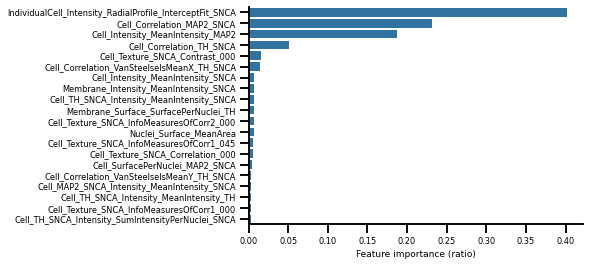

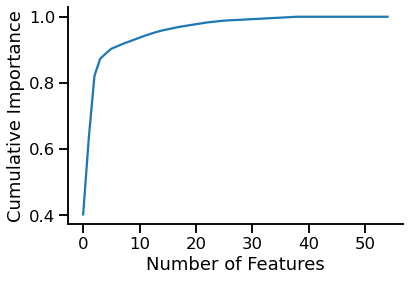

In [15]:
le = LabelEncoder() 
trainY = le.fit_transform(Y)

n=200
feature_importances = np.zeros(df_X_without_correlated.shape[1])
for i in range(n): 
   
    lgb_model = lgb.LGBMClassifier( boosting_type = 'goss', n_estimators = 10000, class_weight = 'balanced')
    train_features, valid_features, train_y, valid_y = train_test_split(df_X_without_correlated, trainY, test_size = 0.1, random_state = i)      
    lgb_model.fit(train_features, train_y, early_stopping_rounds=100, eval_set = [(valid_features, valid_y)], 
              eval_metric = 'auc', verbose = 0)       
    feature_importances += lgb_model.feature_importances_

feature_importances = feature_importances / n
feature_importances = pd.DataFrame({'feature': list(df_X_without_correlated.columns), 'importance': feature_importances}).sort_values('importance', ascending = False)

output_path_LGBM = output_path+'/LightGBM_after_correlations/'

if not os.path.exists(output_path_LGBM):
	os.makedirs(output_path_LGBM, exist_ok=True)

# Evaluate number of features without any significnace for LightGBM classification
zero_features = list(feature_importances[feature_importances['importance'] == 0.0]['feature'])
print('There are %d features with 0.0 importance' % len(zero_features))

feature_importances = feature_importances.sort_values('importance', ascending=False).reset_index()

# Normalize the feature importances to add up to one
feature_importances['importance_normalized'] = feature_importances['importance'] / feature_importances['importance'].sum()
feature_importances['cumulative_importance'] = np.cumsum(feature_importances['importance_normalized'])

#plt.figure(figsize=(10, 20))
#ax = plt.subplot()

df_feature_importances = pd.DataFrame(
    {'Features': feature_importances['feature'],
     'Importance (fraction)': feature_importances['importance_normalized'],
     'cumulative_importance': feature_importances['cumulative_importance']
    })

feature_importances_head20 = feature_importances.head(20)
print(feature_importances_head20)

sns.set_context("talk", font_scale=0.5)
ax = sns.barplot(x="importance_normalized", y="feature", data=feature_importances_head20, color="#1f77b4")
ax.set(xlabel='Feature importance (ratio)', ylabel='')
sns.despine()
plt.savefig(output_path_LGBM+"LightGBM_FeatureContributions_after_PearsonThreshold.pdf", bbox_inches='tight')
plt.show()

# Cumulative importance plot
feature_importances['position'] = list(range(len(feature_importances)))
sns.set_context("talk")
ax1 = sns.lineplot(data=feature_importances, x='position', y='cumulative_importance')
ax1.set(xlabel='Number of Features', ylabel='Cumulative Importance')
sns.despine()
plt.savefig(output_path_LGBM+"LightGBM_CumulativeImportance.pdf", bbox_inches='tight')
plt.show()

Plotting metrics recorded during training...


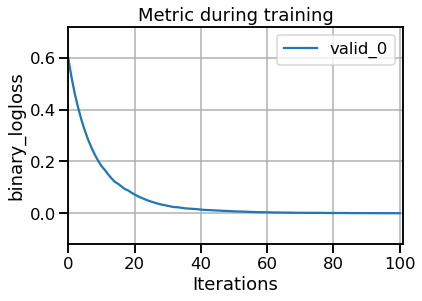

In [16]:
print('Plotting metrics recorded during training...')

ax = lgb.plot_metric( lgb_model)
plt.show()

### Select number of features for LDA based on LightGBM classifier
Pick the number of features that will be used for the subsequent LDA. You can choose all features or select only the contributing ones as determined above. EXAMPLE: If total number of features is 105 and 12 are not contributing, select 93 features for LDA.

In [17]:
n_feat = len(feature_importances['feature'])

nb_feat_select = n_feat - 16

display(nb_feat_select)

39

### LDA Analysis (with feature selection by previous Pearson Correlations Threshold)

0     IndividualCell_Intensity_RadialProfile_Interce...
1                            Cell_Correlation_MAP2_SNCA
2                     Cell_Intensity_MeanIntensity_MAP2
3                              Cell_Correlation_TH_SNCA
4                        Cell_Texture_SNCA_Contrast_000
5            Cell_Correlation_VanSteelselsMeanX_TH_SNCA
6                     Cell_Intensity_MeanIntensity_SNCA
7                 Membrane_Intensity_MeanIntensity_SNCA
8             Cell_TH_SNCA_Intensity_MeanIntensity_SNCA
9                  Membrane_Surface_SurfacePerNuclei_TH
10            Cell_Texture_SNCA_InfoMeasuresOfCorr2_000
11                              Nuclei_Surface_MeanArea
12            Cell_Texture_SNCA_InfoMeasuresOfCorr1_045
13                    Cell_Texture_SNCA_Correlation_000
14                      Cell_SurfacePerNuclei_MAP2_SNCA
15           Cell_Correlation_VanSteelselsMeanY_TH_SNCA
16          Cell_MAP2_SNCA_Intensity_MeanIntensity_SNCA
17              Cell_TH_SNCA_Intensity_MeanInten

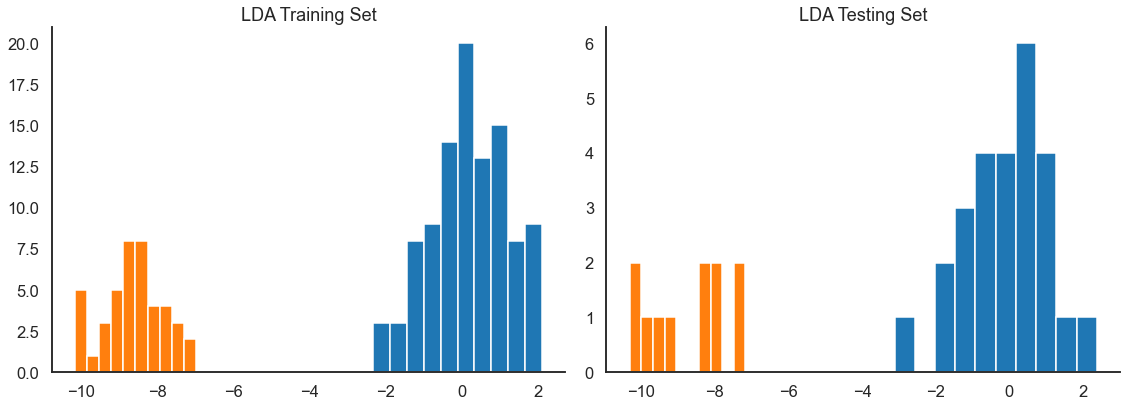

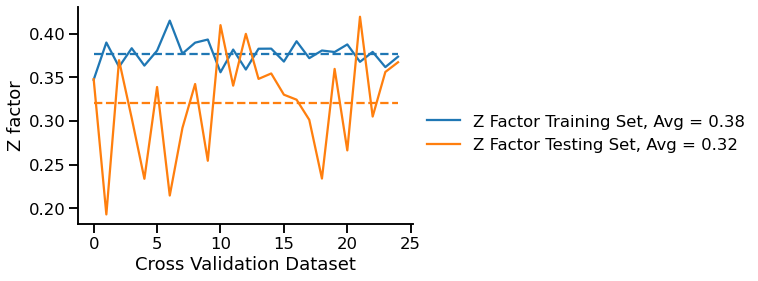

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

DMSO;WT v.s. DMSO;Tripli: Mann-Whitney-Wilcoxon test two-sided, P_val=1.875e-26 U_stat=0.000e+00
DMSO;Tripli v.s. GNE;Tripli: Mann-Whitney-Wilcoxon test two-sided, P_val=6.289e-07 U_stat=3.199e+03
DMSO;Tripli v.s. Mli;Tripli: Mann-Whitney-Wilcoxon test two-sided, P_val=6.186e-01 U_stat=5.594e+03
DMSO;Tripli v.s. PFE;Tripli: Mann-Whitney-Wilcoxon test two-sided, P_val=9.626e-01 U_stat=5.397e+03


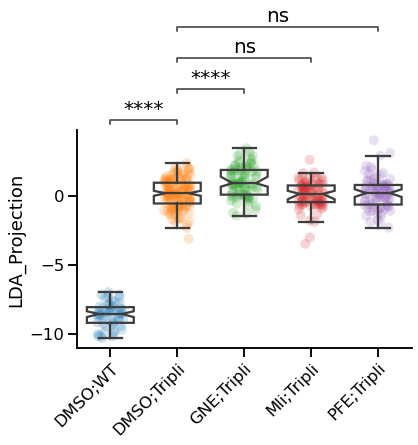

In [18]:
output_path_all = output_path+'/LDA_features_after_correlations/'

if not os.path.exists(output_path_all):
	os.makedirs(output_path_all, exist_ok=True)

train_set_proportion = 0.8
shrink = 'auto'

subset_columns = (feature_importances['feature'])[0:nb_feat_select]
print(subset_columns)

X_subset = df_X_without_correlated[subset_columns]

x_train, x_test, y_train, y_test = train_test_split(X_subset, Y, train_size=train_set_proportion, stratify=Y, random_state=100)

lda_analysis = LDA(solver='eigen', n_components=1, shrinkage=shrink)

print(x_train.columns)

lda_analysis.fit(x_train, y_train)

LDA_train = lda_analysis.transform(x_train)
LDA_test = lda_analysis.transform(x_test)

from sklearn.model_selection import cross_val_score
scores = cross_val_score(lda_analysis, X_subset, Y, cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))


with sns.axes_style("white"), sns.plotting_context("talk"):
	fig, axes = plt.subplots(figsize=(16, 6), nrows=1, ncols=2)
	axes[0].hist(LDA_train[y_train==0], label=ctrl_neg)
	axes[0].hist(LDA_train[y_train==1], label=ctrl_pos)
	axes[0].set_title('LDA Training Set')
	axes[1].hist(LDA_test[y_test==0], label=ctrl_neg)
	axes[1].hist(LDA_test[y_test==1], label=ctrl_pos)
	axes[1].set_title('LDA Testing Set')
	plt.tight_layout()
	sns.despine()
	plt.savefig(output_path_all+'LDA_training_test_set_shrinkage_'+str(shrink)+'_after_correlations.pdf', bbox_inches='tight')
	plt.show()

X_all_cpds_subset = X_all_cpds[subset_columns]

LDA_dmso_and_cpds_subset = lda_analysis.transform(X_all_cpds_subset)

X_all_cpds_subset_lda = X_all_cpds_subset.copy()

X_all_cpds_subset_lda['LDA_Projection'] = LDA_dmso_and_cpds_subset[:,0]
X_all_cpds_subset_lda['tags'] = Y_all_cpds

list_z_train, list_z_test = cross_valid_z_prime(lda_analysis, X_subset, Y, 25, train_set_proportion)

xpoints = range(len(list_z_test))

training = ['Training'] * len(list_z_train)
testing = ['Testing'] * len(list_z_test)

training_df = pd.DataFrame(
    {'Y': list_z_train,
     'X': xpoints,
     'Hue': training
    })

testing_df = pd.DataFrame(
    {'Y': list_z_test,
     'X': xpoints,
     'Hue': testing
    })

test_train = training_df.append(testing_df).reset_index(drop=True)

sns.set_context("talk")                
ax = sns.lineplot(data=test_train, x='X', y='Y', hue='Hue')
ax.set(xlabel='Cross Validation Dataset', ylabel='Z factor')
plt.hlines(np.mean(list_z_train), 0, len(list_z_train)-1, colors=sns.color_palette()[0], linestyles='dashed')
plt.hlines(np.mean(list_z_test), 0, len(list_z_test)-1, colors=sns.color_palette()[1], linestyles='dashed')
sns.despine()
# Put the legend out of the figure and remove title
handles, labels = ax.get_legend_handles_labels()
ax.legend(['Z Factor Training Set, Avg = '+"%.2f" % np.mean(list_z_train), 
           'Z Factor Testing Set, Avg = '+"%.2f" % np.mean(list_z_test)], handles=handles[2:], labels=labels[2:], bbox_to_anchor=(1.02, 0.3), loc=3, borderaxespad=0., 
           frameon=False)
plt.savefig(output_path_all+"LDA_Cross_Validation_Dataset"+str(shrink)+"_after_correlations.pdf", bbox_inches='tight')
plt.show()

# Plotting
sns.set_context("talk")
ax = sns.boxplot(x='tags', y='LDA_Projection', data=X_all_cpds_subset_lda, width=0.7, showfliers=False, zorder=1,
                 order=order, notch=1, bootstrap = 1000)
# Transparancy of boxplot filling color
for patch in ax.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, 0))
s = sns.stripplot(x='tags', y='LDA_Projection', data=X_all_cpds_subset_lda, order=order, size=10, alpha=0.2, jitter=0.2, 
                  zorder=0)
from statannot import add_stat_annotation
# Stat annotations
add_stat_annotation(s, data=X_all_cpds_subset_lda, x='tags', y='LDA_Projection', box_pairs=box_pairs,
               loc='outside', verbose=1, test='Mann-Whitney', comparisons_correction=None,
               perform_stat_test=True, order=order,
               color='0.2', linewidth=1.5,
               fontsize=20)
s.set(xlabel=None)
s.set_xticklabels(s.get_xticklabels(),rotation=45, ha='right', rotation_mode="anchor")
sns.despine()
plt.savefig(output_path_all+"LDA_Projection_All_Conditions_after_correlations_shrinkage_"+str(shrink)+".pdf", bbox_inches='tight')
plt.show()

### SVM Analysis (with feature selection by previous Pearson Correlations Threshold)
Selection of hyperparameters by SciKitLearn's grid search using cross validation.

In [19]:
train_set_proportion = 0.8

x_train_grid, x_test_grid, y_train_grid, y_test_grid = train_test_split(df_X_without_correlated[subset_columns], Y, train_size=train_set_proportion, stratify=Y, random_state=100)

# Set the parameters by cross-validation

tested_C = list(np.linspace(0.05, 1., 20))
tested_C.append(1.5)
tested_C.append(2)
tested_C.append(3)
tested_C.append(5)
tested_C.append(10)

tuned_parameters = [
    {"kernel": ["rbf"], "gamma": ['scale'], "C": tested_C}, # np.logspace(-2, 1, 100)
    {"kernel": ["poly"], "gamma": ['scale'], "C": tested_C},
    {"kernel": ["linear"], "C": tested_C},
]

best_C = []

clf = SVC()

for parameters in tuned_parameters:
    
    cv = GridSearchCV(clf, param_grid=parameters, scoring="f1", 
                      cv=StratifiedShuffleSplit(n_splits=4, test_size=1.-train_set_proportion, random_state=0))
    cv.fit(df_X_without_correlated[subset_columns], Y)
    C = cv.best_estimator_
    best_C.append(C)

    print(parameters)
    print(C)

print()
print('GridSearchCV Optimized for rbf kernel :')
print("\'kernel\': [\'rbf\'], \'gamma\': [\'scale\'], \'C\': [",best_C[0].C,"]")
print()

# scores = ["precision", "recall"]

# for score in scores:
#     print("# Tuning hyper-parameters for %s" % score)
#     print()

#     clf = GridSearchCV(SVC(), tuned_parameters, scoring="%s_macro" % score)
#     clf.fit(x_train_grid, y_train_grid)

#     print("Best parameters set found on development set:")
#     print()
#     print(clf.best_params_)
#     print()
#     print("Grid scores on development set:")
#     print()
#     means = clf.cv_results_["mean_test_score"]
#     stds = clf.cv_results_["std_test_score"]
#     for mean, std, params in zip(means, stds, clf.cv_results_["params"]):
#         print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
#     print()

#     print("Detailed classification report:")
#     print()
#     print("The model is trained on the full development set.")
#     print("The scores are computed on the full evaluation set.")
#     print()
#     y_true_grid, y_pred_grid = y_test_grid, clf.predict(x_test_grid)
#     print(classification_report(y_true_grid, y_pred_grid))
#     print()

{'kernel': ['rbf'], 'gamma': ['scale'], 'C': [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.39999999999999997, 0.44999999999999996, 0.49999999999999994, 0.5499999999999999, 0.6, 0.65, 0.7, 0.75, 0.7999999999999999, 0.85, 0.9, 0.95, 1.0, 1.5, 2, 3, 5, 10]}
SVC(C=0.1)
{'kernel': ['poly'], 'gamma': ['scale'], 'C': [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.39999999999999997, 0.44999999999999996, 0.49999999999999994, 0.5499999999999999, 0.6, 0.65, 0.7, 0.75, 0.7999999999999999, 0.85, 0.9, 0.95, 1.0, 1.5, 2, 3, 5, 10]}
SVC(C=0.05, kernel='poly')
{'kernel': ['linear'], 'C': [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.39999999999999997, 0.44999999999999996, 0.49999999999999994, 0.5499999999999999, 0.6, 0.65, 0.7, 0.75, 0.7999999999999999, 0.85, 0.9, 0.95, 1.0, 1.5, 2, 3, 5, 10]}
SVC(C=0.05, kernel='linear')

GridSearchCV Optimized for rbf kernel :
'kernel': ['rbf'], 'gamma': ['scale'], 'C': [ 0.1 ]



### SVM classifier with tuned hyperparameters

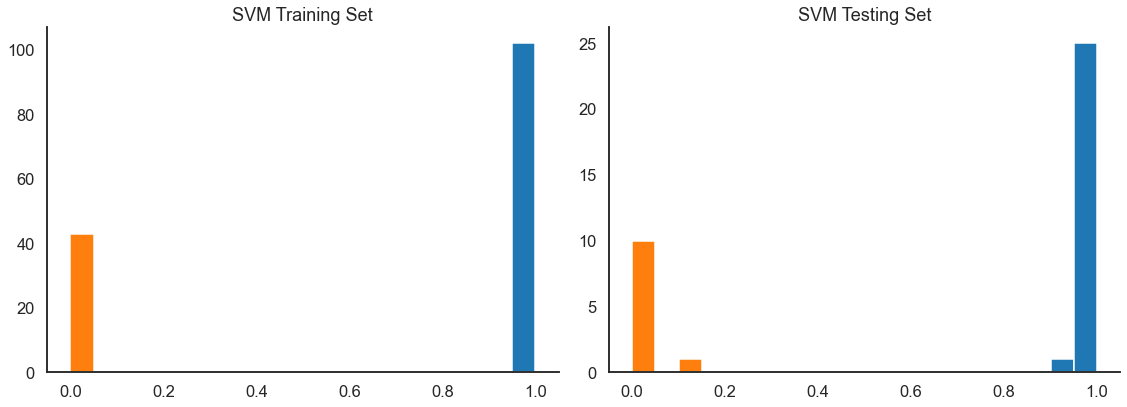

Cross Valid Accuracy: 1.00 (+/- 0.00)


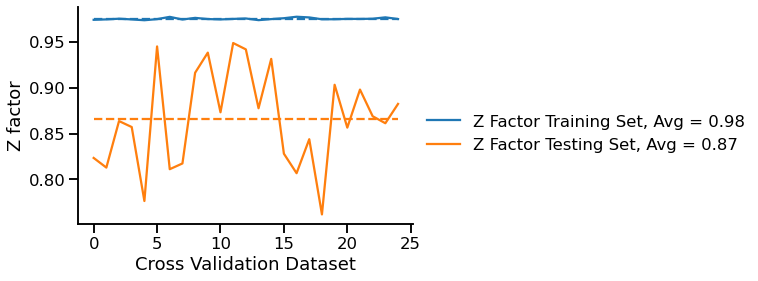

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

DMSO;WT v.s. DMSO;Tripli: Mann-Whitney-Wilcoxon test two-sided, P_val=1.875e-26 U_stat=0.000e+00
DMSO;Tripli v.s. GNE;Tripli: Mann-Whitney-Wilcoxon test two-sided, P_val=4.131e-22 U_stat=9.600e+03
DMSO;Tripli v.s. Mli;Tripli: Mann-Whitney-Wilcoxon test two-sided, P_val=3.951e-01 U_stat=5.748e+03
DMSO;Tripli v.s. PFE;Tripli: Mann-Whitney-Wilcoxon test two-sided, P_val=3.673e-02 U_stat=6.289e+03


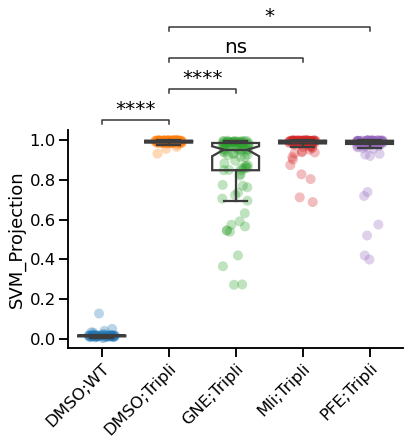

In [20]:
output_path_all = output_path+'/SVM_features_after_correlations/'

if not os.path.exists(output_path_all):
	os.makedirs(output_path_all, exist_ok=True)

C = 1 #best_C[0].C # clf.best_params_['C']

svm_analysis = SVC(probability=True, kernel='rbf', C=C, gamma='scale')
svm_analysis.fit(x_train, y_train)

SVM_train = svm_analysis.predict_proba(x_train)
SVM_test = svm_analysis.predict_proba(x_test)

binwidth = 0.05
bins = np.arange(0, 1. + binwidth, binwidth)

with sns.axes_style("white"), sns.plotting_context("talk"):
	fig, axes = plt.subplots(figsize=(16, 6), nrows=1, ncols=2)
	axes[0].hist(SVM_train[y_train==0,0], label=ctrl_neg, bins=bins)
	axes[0].hist(SVM_train[y_train==1,0], label=ctrl_pos, bins=bins)
	axes[0].set_title('SVM Training Set')
	axes[1].hist(SVM_test[y_test==0,0], label=ctrl_neg, bins=bins)
	axes[1].hist(SVM_test[y_test==1,0], label=ctrl_pos, bins=bins)
	axes[1].set_title('SVM Testing Set')
	plt.tight_layout()
	sns.despine()
	plt.savefig(output_path_all+'SVM_training_test_set_after_correlations.pdf', bbox_inches='tight')
	plt.show()

from sklearn.model_selection import cross_val_score
scores = cross_val_score(svm_analysis, X_subset, Y, cv=10)
print("Cross Valid Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

SVM_dmso_and_cpds = svm_analysis.predict_proba(X_all_cpds_subset)
X_all_cpds_svm = X_all_cpds_subset.copy()

X_all_cpds_svm['SVM_Projection'] = SVM_dmso_and_cpds[:,0]
X_all_cpds_svm['tags'] = Y_all_cpds


list_z_train, list_z_test = cross_valid_z_prime_svm(svm_analysis, X_subset, Y, 25, train_set_proportion, output_path_all)

xpoints = range(len(list_z_test))

training = ['Training'] * len(list_z_train)
testing = ['Testing'] * len(list_z_test)

training_df = pd.DataFrame(
    {'Y': list_z_train,
     'X': xpoints,
     'Hue': training
    })

testing_df = pd.DataFrame(
    {'Y': list_z_test,
     'X': xpoints,
     'Hue': testing
    })

test_train = training_df.append(testing_df).reset_index(drop=True)

sns.set_context("talk")                
ax = sns.lineplot(data=test_train, x='X', y='Y', hue='Hue')
ax.set(xlabel='Cross Validation Dataset', ylabel='Z factor')
plt.hlines(np.mean(list_z_train), 0, len(list_z_train)-1, colors=sns.color_palette()[0], linestyles='dashed')
plt.hlines(np.mean(list_z_test), 0, len(list_z_test)-1, colors=sns.color_palette()[1], linestyles='dashed')
sns.despine()
# Put the legend out of the figure and remove title
handles, labels = ax.get_legend_handles_labels()
ax.legend(['Z Factor Training Set, Avg = '+"%.2f" % np.mean(list_z_train), 
           'Z Factor Testing Set, Avg = '+"%.2f" % np.mean(list_z_test)], handles=handles[2:], labels=labels[2:], bbox_to_anchor=(1.02, 0.3), loc=3, borderaxespad=0., 
           frameon=False)
plt.savefig(output_path_all+'SVM_CV_ZFactor_after_correlations.pdf', bbox_inches='tight')
plt.show()

X_all_cpds_pl_well = X_all_cpds_subset.reset_index()
plates = X_all_cpds_pl_well['Plate']

list_tags_plates = []
for i in range(len(Y_all_cpds)):
    list_tags_plates.append(Y_all_cpds[i]+'_'+plates[i])
    
X_all_cpds_svm['tags_plate'] = list_tags_plates

sns.set_context("talk")

ax = sns.boxplot(x='tags', y='SVM_Projection', data=X_all_cpds_svm, width=0.7, showfliers=False, zorder=1,
                 order=order, notch=1, bootstrap = 1000)
# Transparancy of boxplot filling color
for patch in ax.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, 0))
s = sns.stripplot(x='tags', y='SVM_Projection', data=X_all_cpds_svm, order=order, size=10, alpha=0.3, jitter=0.2, zorder=0)
from statannot import add_stat_annotation

add_stat_annotation(s, data=X_all_cpds_svm, x='tags', y='SVM_Projection', box_pairs=box_pairs,
               loc='outside', verbose=1, test='Mann-Whitney', comparisons_correction=None,
               perform_stat_test=True, order=order,
               color='0.2', linewidth=1.5,
               fontsize=20)
s.set(xlabel=None)
s.set_xticklabels(s.get_xticklabels(),rotation=45, ha='right', rotation_mode="anchor")
sns.despine()
plt.savefig(output_path_all+"SVM_Projection_All_Conditions_after_correlations.pdf", bbox_inches='tight')
plt.show()


### Function to calculate Z Factor :

In [21]:
def get_acc_zfactor(lda_analysis, x_train, y_train, x_test, y_test):

    lda_analysis.fit(x_train, y_train)
    
    accuracy_train = lda_analysis.score(x_train, y_train)
    accuracy_test = lda_analysis.score(x_test, y_test)

    x_neg_train = lda_analysis.transform(x_train[y_train == 0])
    x_pos_train = lda_analysis.transform(x_train[y_train == 1])

    z_train = 1.0 - 3.0 * (np.std(x_neg_train) + np.std(x_pos_train)) / np.abs(
        np.mean(x_neg_train) - np.mean(x_pos_train))

    x_neg_test = lda_analysis.transform(x_test[y_test == 0])
    x_pos_test = lda_analysis.transform(x_test[y_test == 1])

    z_test = 1.0 - 3.0 * (np.std(x_neg_test) + np.std(x_pos_test)) / np.abs(np.mean(x_neg_test) - np.mean(x_pos_test))

    return accuracy_train, accuracy_test, z_train, z_test

### LOO Features, LDA :

In [22]:
def LOO_features_LDA(X, Y, train_set_proportion = 0.8, shrink = 'auto', seed=100):

    lda_analysis = LDA(solver='eigen', n_components=1, shrinkage=shrink)

    x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size=train_set_proportion, stratify=Y, random_state=seed)

    accuracy_train, accuracy_test, z_train, z_test = get_acc_zfactor(lda_analysis, x_train, y_train, x_test, y_test)

    list_feature_removed = []
    list_acc_train = []
    list_acc_test = []
    list_z_train = []
    list_z_test = []

    for f in x_train.columns:

        x_train_loo = x_train.drop([f], axis=1)
        x_test_loo = x_test.drop([f], axis=1)

        accuracy_train_loo, accuracy_test_loo, z_train_loo, z_test_loo = get_acc_zfactor(lda_analysis, x_train_loo, y_train, x_test_loo, y_test)

        list_feature_removed.append(f)
        list_acc_train.append(accuracy_train_loo)
        list_acc_test.append(accuracy_test_loo)
        list_z_train.append(z_train_loo)
        list_z_test.append(z_test_loo)
    
    return accuracy_train, accuracy_test, z_train, z_test, list_feature_removed, list_acc_train, list_acc_test, list_z_train, list_z_test

### Leave One Out based on ZFactor, LDA
Computes the ZFactor shift removing one feature to the SVM classification.

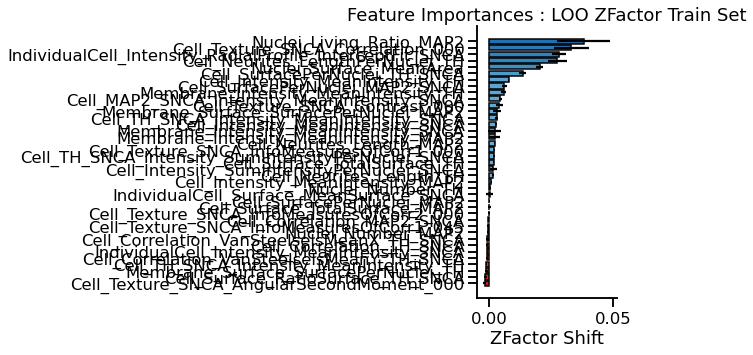

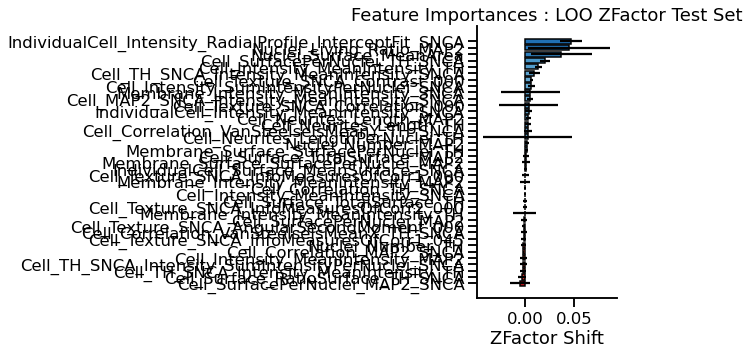

In [23]:
output_path_loo = output_path+'/LOO_Results/'

if not os.path.exists(output_path_loo):
	os.makedirs(output_path_loo, exist_ok=True)

XLOO = X_subset.copy()

CV = 3

lacc_train, lacc_test, lztrain, lztest, llfeature_removed, llacc_train, llacc_test, llz_train, llz_test = [], [], [], [], [], [], [], [], []

for crossval in range(CV):
        acc_train, acc_test, ztrain, ztest, lfeature_removed, lacc_train, lacc_test, lz_train, lz_test = LOO_features_LDA(XLOO, Y, train_set_proportion = 0.8, shrink = 'auto', seed=crossval)
        lacc_train.append(acc_train)
        lacc_test.append(acc_test)
        lztrain.append(ztrain)
        lztest.append(ztest)
        llfeature_removed.append(lfeature_removed)
        llacc_train.append(lacc_train)
        llacc_test.append(lacc_test)
        llz_train.append(lz_train)
        llz_test.append(lz_test)


vec_cv_ztrain = []
vec_cv_ztest = []


for i, val in enumerate(lztrain):
        vec_cv_ztrain.append(-np.array(llz_train[i]) + lztrain[i])
        vec_cv_ztest.append(-np.array(llz_test[i]) + lztest[i])

df_loo_lda = pd.DataFrame()

# display(vec_cv_ztrain)

df_loo_lda['Feature'] = lfeature_removed
df_loo_lda['Diff_ZTrain'] = np.mean(vec_cv_ztrain, axis=0)
df_loo_lda['Diff_ZTest'] = np.mean(vec_cv_ztest, axis=0)
df_loo_lda['std_ZTrain'] = np.std(vec_cv_ztrain, axis=0)
df_loo_lda['std_ZTest'] = np.std(vec_cv_ztest, axis=0)

# display(df_loo_lda['Diff_ZTrain'])
# display(df_loo_lda['std_ZTrain'])

df_loo_lda.sort_values(['Diff_ZTrain'], inplace=True)

my_cmap_red = plt.get_cmap("Reds")
my_cmap_blue = plt.get_cmap("Blues")

my_colors = []
for value in df_loo_lda['Diff_ZTrain']:
        if value < 0:
                my_colors.append(my_cmap_red(.5+np.abs(0.25*value/df_loo_lda['Diff_ZTrain'].min())))
        else:
                my_colors.append(my_cmap_blue(.5+np.abs(0.25*value/df_loo_lda['Diff_ZTrain'].max())))

f, ax = plt.subplots(figsize=(2.5,5))

ax.barh(range(len(df_loo_lda)),
        df_loo_lda['Diff_ZTrain'],
        align='center', edgecolor='k', xerr=df_loo_lda['std_ZTrain'], color=my_colors)

ax.set_yticks(range(len(df_loo_lda)))
ax.set_yticklabels(df_loo_lda['Feature'])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.xlabel('ZFactor Shift');
plt.title('Feature Importances : LOO ZFactor Train Set')
plt.savefig(output_path_loo+"LOO_LDA_Train_Set.pdf", bbox_inches='tight')
plt.show()

df_loo_lda.sort_values(['Diff_ZTest'], inplace=True)

my_cmap_red = plt.get_cmap("Reds")
my_cmap_blue = plt.get_cmap("Blues")

my_colors = []
for value in df_loo_lda['Diff_ZTest']:
        if value < 0:
                my_colors.append(my_cmap_red(.5+np.abs(0.25*value/df_loo_lda['Diff_ZTest'].min())))
        else:
                my_colors.append(my_cmap_blue(.5+np.abs(0.25*value/df_loo_lda['Diff_ZTest'].max())))

f, ax = plt.subplots(figsize=(2.5,5))

ax.barh(range(len(df_loo_lda)),
        df_loo_lda['Diff_ZTest'],
        align='center', edgecolor='k', xerr=df_loo_lda['std_ZTest'], color=my_colors)

ax.set_yticks(range(len(df_loo_lda)))
ax.set_yticklabels(df_loo_lda['Feature'])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.xlabel('ZFactor Shift');
plt.title('Feature Importances : LOO ZFactor Test Set')
plt.savefig(output_path_loo+"LOO_LDA_Test_Set.pdf", bbox_inches='tight')
plt.show()


In [24]:
def get_acc_zfactor_svm(svm_analysis, x_train, y_train, x_test, y_test):

    svm_analysis.fit(x_train, y_train)
    
    accuracy_train = svm_analysis.score(x_train, y_train)
    accuracy_test = svm_analysis.score(x_test, y_test)

    x_neg_train = svm_analysis.predict_proba(x_train[y_train == 0])[:,0]
    x_pos_train = svm_analysis.predict_proba(x_train[y_train == 1])[:,0]

    z_train = 1.0 - 3.0 * (np.std(x_neg_train) + np.std(x_pos_train)) / np.abs(
        np.mean(x_neg_train) - np.mean(x_pos_train))

    x_neg_test = svm_analysis.predict_proba(x_test[y_test == 0])[:,0]
    x_pos_test = svm_analysis.predict_proba(x_test[y_test == 1])[:,0]

    z_test = 1.0 - 3.0 * (np.std(x_neg_test) + np.std(x_pos_test)) / np.abs(np.mean(x_neg_test) - np.mean(x_pos_test))

    # print(z_train, z_test)

    return accuracy_train, accuracy_test, z_train, z_test

### LOO Features, SVM :

In [25]:
def LOO_features_SVM(X, Y, train_set_proportion, C, seed=100):

    svm_analysis = SVC(probability=True, kernel='rbf', C=C, gamma='scale')
    
    x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size=train_set_proportion, stratify=Y, random_state=seed)

    accuracy_train, accuracy_test, z_train, z_test = get_acc_zfactor_svm(svm_analysis, x_train, y_train, x_test, y_test)

    list_feature_removed = []
    list_acc_train = []
    list_acc_test = []
    list_z_train = []
    list_z_test = []

    for f in x_train.columns:

        x_train_loo = x_train.drop([f], axis=1)
        x_test_loo = x_test.drop([f], axis=1)

        accuracy_train_loo, accuracy_test_loo, z_train_loo, z_test_loo = get_acc_zfactor_svm(svm_analysis, x_train_loo, y_train, x_test_loo, y_test)

        list_feature_removed.append(f)
        list_acc_train.append(accuracy_train_loo)
        list_acc_test.append(accuracy_test_loo)
        list_z_train.append(z_train_loo)
        list_z_test.append(z_test_loo)
    
    return accuracy_train, accuracy_test, z_train, z_test, list_feature_removed, list_acc_train, list_acc_test, list_z_train, list_z_test

### Leave One Out based on ZFactor, SVM
Computes the ZFactor shift removing one feature to the SVM classification.

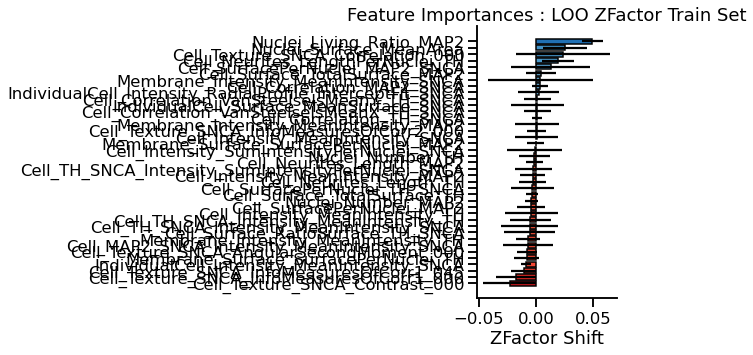

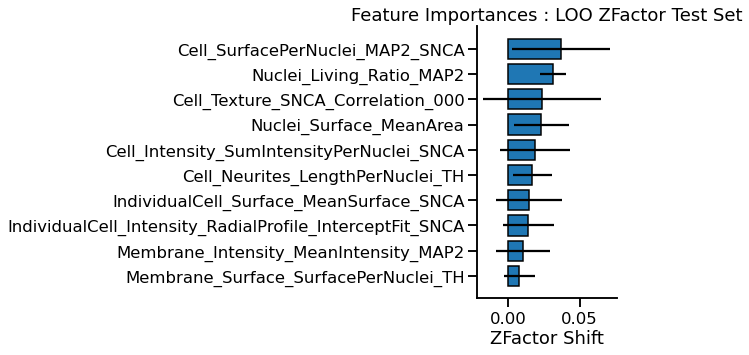

In [26]:
XLOO = X_subset.copy()
C = best_C[0].C

CV = 3

lacc_train, lacc_test, lztrain, lztest, llfeature_removed, llacc_train, llacc_test, llz_train, llz_test = [], [], [], [], [], [], [], [], []

for crossval in range(CV):
        acc_train, acc_test, ztrain, ztest, lfeature_removed, lacc_train, lacc_test, lz_train, lz_test = LOO_features_SVM(XLOO, Y, train_set_proportion = 0.8, C=C, seed=crossval)
        lacc_train.append(acc_train)
        lacc_test.append(acc_test)
        lztrain.append(ztrain)
        lztest.append(ztest)
        llfeature_removed.append(lfeature_removed)
        llacc_train.append(lacc_train)
        llacc_test.append(lacc_test)
        llz_train.append(lz_train)
        llz_test.append(lz_test)


vec_cv_ztrain = []
vec_cv_ztest = []


for i, val in enumerate(lztrain):
        vec_cv_ztrain.append(-np.array(llz_train[i]) + lztrain[i])
        vec_cv_ztest.append(-np.array(llz_test[i]) + lztest[i])

df_loo_svm = pd.DataFrame()

# display(vec_cv_ztrain)

df_loo_svm['Feature'] = lfeature_removed
df_loo_svm['Diff_ZTrain'] = np.mean(vec_cv_ztrain, axis=0)
df_loo_svm['Diff_ZTest'] = np.mean(vec_cv_ztest, axis=0)
df_loo_svm['std_ZTrain'] = np.std(vec_cv_ztrain, axis=0)
df_loo_svm['std_ZTest'] = np.std(vec_cv_ztest, axis=0)

df_loo_svm.sort_values(['Diff_ZTrain'], inplace=True)

my_cmap_red = plt.get_cmap("Reds")
my_cmap_blue = plt.get_cmap("Blues")

my_colors = []
for value in df_loo_svm['Diff_ZTrain']:
        if value < 0:
                my_colors.append(my_cmap_red(.5+np.abs(0.25*value/df_loo_svm['Diff_ZTrain'].min())))
        else:
                my_colors.append(my_cmap_blue(.5+np.abs(0.25*value/df_loo_svm['Diff_ZTrain'].max())))

f, ax = plt.subplots(figsize=(2.5,5))

ax.barh(range(len(df_loo_svm)),
        df_loo_svm['Diff_ZTrain'],
        xerr=df_loo_svm['std_ZTest'],
        align='center', edgecolor='k', color=my_colors)

ax.set_yticks(range(len(df_loo_svm)))
ax.set_yticklabels(df_loo_svm['Feature'])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.xlabel('ZFactor Shift')
plt.title('Feature Importances : LOO ZFactor Train Set')
plt.savefig(output_path_loo+"LOO_SVM_Train_Set.pdf", bbox_inches='tight')
plt.show()

df_loo_svm.sort_values(['Diff_ZTest'], inplace=True)

my_cmap_red = plt.get_cmap("Reds")
my_cmap_blue = plt.get_cmap("Blues")

my_colors = []
for value in df_loo_svm['Diff_ZTest']:
        if value < 0:
                my_colors.append(my_cmap_red(.5+np.abs(0.25*value/df_loo_svm['Diff_ZTest'].min())))
        else:
                my_colors.append(my_cmap_blue(.5+np.abs(0.25*value/df_loo_svm['Diff_ZTest'].max())))

f, ax = plt.subplots(figsize=(2.5,5))

df_loo_svm = df_loo_svm.sort_values('Diff_ZTest')

df_loo_svm = df_loo_svm.tail(10)

ax.barh(range(len(df_loo_svm)),
        df_loo_svm['Diff_ZTest'],
        xerr=df_loo_svm['std_ZTest'],
        align='center', edgecolor='k', color='#1f77b4')

ax.set_yticks(range(len(df_loo_svm)))
ax.set_yticklabels(df_loo_svm['Feature'])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.xlabel('ZFactor Shift')
plt.title('Feature Importances : LOO ZFactor Test Set')
plt.savefig(output_path_loo+"LOO_SVM_Test_Set.pdf", bbox_inches='tight')
plt.show()